### Compare CTSM simulation forced with NLDAS data over Gothic, CO, and billy bar's observations
Created by Will Wieder, Jan 2024


In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

## Open observations from gothic, billy bar data
- Prather, R. M., Inouye, B. D., Underwood, N., Dalton, R., & barr, billy. (2023, June 26). RMBL Weather 1975-2022. https://doi.org/10.17605/OSF.IO/8EZKA
- Dowloaded from https://osf.io/8ezka/ Dec 12, 2023
- Crested Butte weather also avaialbe, but not used here

In [2]:
obs_path = '/glade/campaign/cgd/tss/people/wwieder/gothic/snodgrass_obs/'
obs_in = obs_path + 'barr-weather-data-1975-2022.csv'
obs_in = pd.read_csv(obs_in).drop(columns=['site'])
obs_in

,latitude,longitude,elevation,snow.year,month,day,minimum.temperature,maximum.temperature,new.snow.cm,new.water.inches,total.snow.cm,total.water.inches,snow.on.ground.cm,rainfall,total.rainfall.inches
0,38.962915,-106.992764,2916.9,197475,C,1,NaN,NaN,0.0,NaN,79.0,NaN,46.0,NaN,NaN
1,38.962915,-106.992764,2916.9,197475,C,2,NaN,NaN,4.0,NaN,83.0,NaN,37.0,NaN,NaN
2,38.962915,-106.992764,2916.9,197475,C,3,NaN,NaN,6.0,NaN,89.0,NaN,39.0,NaN,NaN
3,38.962915,-106.992764,2916.9,197475,C,4,NaN,NaN,2.0,NaN,91.0,NaN,37.0,NaN,NaN
4,38.962915,-106.992764,2916.9,197475,C,5,NaN,NaN,0.0,NaN,91.0,NaN,33.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14328,38.962915,-106.992764,2916.9,202223,D,27,-12.5,5.0,0.0,0.00,177.0,5.69,55.0,0.0,2.86
14329,38.962915,-106.992764,2916.9,202223,D,28,-3.5,0.0,34.0,1.09,211.0,6.78,88.0,0.0,2.86
14330,38.962915,-106.992764,2916.9,202223,D,29,-22.5,-8.5,9.0,0.25,220.0,7.03,90.0,0.0,2.86
14331,38.962915,-106.992764,2916.9,202223,D,30,-21.5,-6.0,4.0,0.10,224.0,7.13,93.0,0.0,2.86


In [3]:
#Replace month letter with actual dates
# A = Sept, B=Oct, ect
obs_in = obs_in.replace({"month": {'A':'9', 'B':'10', 'C':'11', 'D':'12', 'E':'1', 'F':'2', 
                                   'G':'3', 'H':'4',  'I':'5' , 'J':'6' , 'K':'7', 'L':'8'}})
obs_in['month'] = pd.to_numeric(obs_in.month)

#create year from snow.year variable 
obs_in['snow_year'] = pd.to_numeric(obs_in['snow.year'].astype(str).str[:4])

# create cumulative sum of precip, 
#   This should = total.water.inches`
obs_in['total.water.cm'] = obs_in['total.water.inches'] * 2.54
obs_in['new.water.cm'] = obs_in['new.water.inches'] * 2.54
obs_in['sum.water.cm'] = obs_in['new.water.cm'].groupby(obs_in['snow_year']).cumsum()

#billy's "snow year" ran from September through August.
# Need to add 1 for Jan-Aug to get calendar year
obs_in['year'] = obs_in['snow_year'].where(obs_in.month>=9,other=obs_in['snow_year']+1)
obs_in[960:975]
obs_in[900:913]
skip=6165
#obs_in[(skip):(15+skip)]
#obs_in.head

In [4]:
# add date.time
obs_in['date'] = pd.to_datetime(dict(year=obs_in.year, month=obs_in.month, day=obs_in.day))
obs_in['day_of_year'] = obs_in['date'].dt.dayofyear
obs_in['day_of_wateryear'] = (obs_in['day_of_year']+365-244).where(obs_in.month<9,other=obs_in['day_of_year']-244)

In [5]:
obs_in.set_index('date', inplace=True)
#obs_in[900:913]
#plt.plot(obs_in['minimum.temperature'])

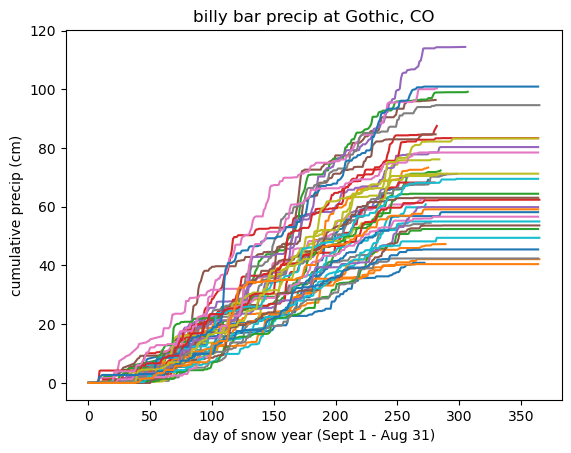

In [6]:
for i in range(1980,2022,1):
    x = obs_in['day_of_wateryear'].where(obs_in['snow_year']==i)
    y = obs_in['sum.water.cm'].where(obs_in['snow_year']==i)
    y2 = obs_in['total.water.cm'].where(obs_in['snow_year']==i)
    plt.plot(x,(y2), label=i)

plt.title('billy bar precip at Gothic, CO')
plt.xlabel('day of snow year (Sept 1 - Aug 31)')
plt.ylabel('cumulative precip (cm)') ;

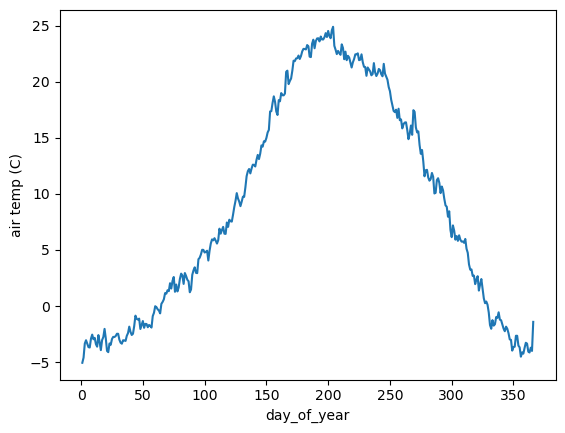

In [7]:
test = obs_in.groupby(obs_in.day_of_year).mean()
#test = obs_in.groupby([(obs_in.index.month), (obs_in.index.day)]).mean()
test['maximum.temperature'].plot() 
plt.ylabel('air temp (C)');

### Read in soil temp and moisture data from Austin

In [8]:
obs_soil = obs_path + 'snodgrass_soil_data_09_24.csv'
obs_soil = pd.read_csv(obs_soil)
obs_soil['date'] = pd.to_datetime(obs_soil['date'])
obs_soil.head(5)

,site,elevation,date,AirT_C_Avg,Rain_mm_Tot,SlrFD_W_Avg,VWC_1_Avg,VWC_2_Avg,VWC_3_Avg,T_1_Avg,T_2_Avg,T_3_Avg
0,low_aspen,3023.0,2021-07-23,14.70,0.0,148.8,0.091,0.097,0.083,11.31,13.45,13.42
1,low_aspen,3023.0,2021-07-23,16.14,0.0,189.2,0.091,0.096,0.083,11.32,13.41,13.45
2,low_aspen,3023.0,2021-07-23,17.39,0.0,329.0,0.091,0.096,0.082,11.32,13.37,13.53
3,low_aspen,3023.0,2021-07-23,18.63,0.0,867.0,0.091,0.096,0.082,11.32,13.33,13.66
4,low_aspen,3023.0,2021-07-23,20.22,0.0,875.0,0.091,0.096,0.082,11.31,13.30,13.83


Text(0, 0.5, 'Soil Moisture, 15 cm')

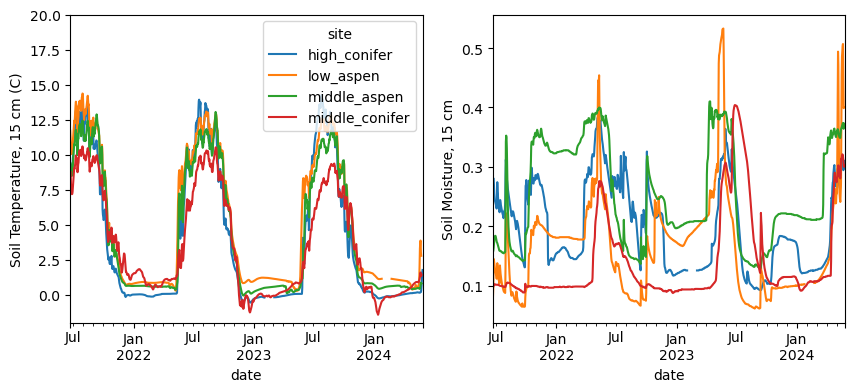

In [9]:
#obs_soil.set_index('date', inplace=True)
#obs_soil.set_index('site', inplace=True)
day_soil = obs_soil.groupby([obs_soil.date,obs_soil.site]).mean().unstack()

fig, axs = plt.subplots(1, 2, figsize=(10,4))
day_soil.T_2_Avg.plot(ax=axs[0], legend='lower left') 
axs[0].set_ylabel('Soil Temperature, 15 cm (C)')
axs[0].set_ylim(-2,20)
day_soil.VWC_2_Avg.plot(ax=axs[1], legend=False) ;
axs[1].set_ylabel('Soil Moisture, 15 cm')


Text(0, 0.5, 'Soil Moisture, 50 cm')

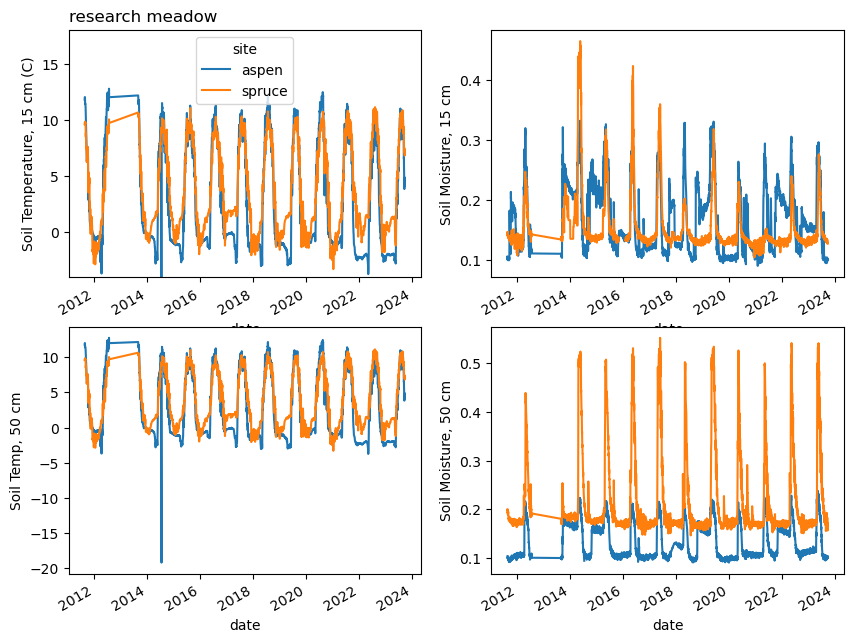

In [10]:
obs_soil = obs_path + 'research_meadow_soil_env.csv'
obs_soil = pd.read_csv(obs_soil)
obs_soil['date'] = pd.to_datetime(obs_soil['date'])
day_soil = obs_soil.groupby([obs_soil.date,obs_soil.site]).mean().unstack()

fig, axs = plt.subplots(2, 2, figsize=(10,8))
day_soil.st15.plot(ax=axs[0,0], legend='lower left') 
axs[0,0].set_ylabel('Soil Temperature, 15 cm (C)')
axs[0,0].set_ylim(-4,18)
axs[0,0].set_title('research meadow',loc='left')
day_soil.vwc15.plot(ax=axs[0,1], legend=False) ;
axs[0,1].set_ylabel('Soil Moisture, 15 cm')
day_soil.st15.plot(ax=axs[1,0], legend=False) ;
axs[1,0].set_ylabel('Soil Temp, 50 cm')

day_soil.vwc50.plot(ax=axs[1,1], legend=False) ;
axs[1,1].set_ylabel('Soil Moisture, 50 cm')


### Read in meterological data from NLDAS

1919.6495361328125
2399.56156992497


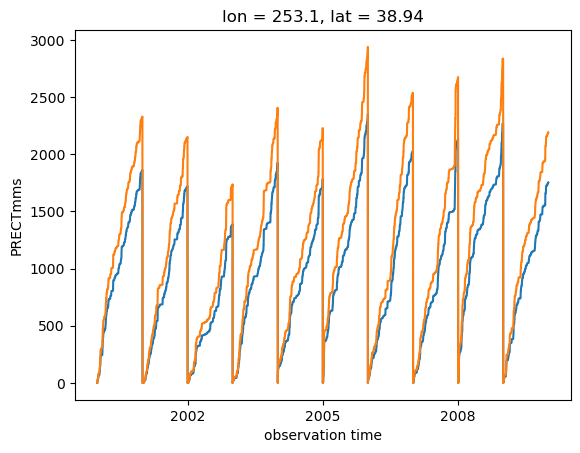

In [11]:
# Check that precip changes worked as intended (
temp1 = '/glade/derecho/scratch/wwieder/nldas/gothic/clmforc.NLDAS2.c2020.Precip.gothic.2000-2009.nc'
temp2 = '/glade/derecho/scratch/wwieder/nldas/gothic/clmforc.NLDAS2.c2020.Precip1.25.gothic.2000-2009.nc'
temp1 = xr.open_dataset(temp1, decode_times=True)
temp2 = xr.open_dataset(temp2, decode_times=True)
temp1 = temp1.PRECTmms.isel(lat=0,lon=0).groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
temp2 = temp2.PRECTmms.isel(lat=0,lon=0).groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
print(temp1.groupby('time.dayofyear').mean().max().values )
print(temp2.groupby('time.dayofyear').mean().max().values )
temp1.plot()
temp2.plot() ;

## Read in data from simulations
- test3 = SP simulations with 100% PFT1, needleleaf evergreen tree – temperate
- test2_trans, BGC simulations as above
- also ran with a deciduous boreal tree (aspen), but veg died.


In [12]:
# Cheyenne runs
# NLDAS forcing out of the bos
# Melt too slow, even when model calculates LW
#exp = 'test3' # 'test2_trans'
#fin = '/glade/campaign/cgd/tss/people/wwieder/cheyenne_archive/nldas/gothic/archive/'+exp+'/lnd/hist/'


## Derecho Runs
# Climatology of observed Shortwave only, model calculated LW
# Melt too slow w/ out higher temperatures, SW, and LW
#exp = ['aspen_SP_obsTSL_PPT1.25','aspen_obsSW_noLW_sp'] #''

#  -- climatology of observed TBOT, Short and Longwave radiation
#  -- NLDAS precip*125%
# Melt and Snow looks OK, but Low IAV or soil temperatures
#exp = ['aspen_SP_obsTSL_PPT1.25','evergreen_SP_obsTSL_PPT1.25'] #'aspen_obsSW_noLW_sp'

#  -- climatology of observed Short and Longwave radiation, 
#  -- NLDAS TBOT & precip*125%
# 2 years with late melt using climatology of Snody observed radiation
#exp = ['aspen_SP_obsRad_PPT1.25','aspen_SP_obsTSL_PPT1.25'] 
#exp = ['aspen_SP_obsRad_PPT1.25','evergreen_SP_obsRad_PPT1.25'] 

#  -- climatology of observed Short and Longwave radiation, 
#  -- NLDAS TBOT+1.5 & precip*125%
# Trying to get appropriate melt date while maintaining variability in soil temperatures
#exp = ['aspen_sp52.028_soilMods_obsRad_PPT1.25','evergreen_sp52.028_soilMods_obsRad_PPT1.25'] 
exp = ['ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25','ssp370_evergreen_sp52.028_soilMods2_obsRad_PPT1.25'] 
#exp = ['aspen_SP_obsRad_PPT1.25_T1.5','aspen_obsTSL_sp']
#exp = ['aspen_sp52.023_obsRad_PPT1.25','aspen_SP_obsRad_PPT1.25'] 
#exp = ['evergreen_SP_obsRad_PPT1.25_T1.5','evergreen_SP_obsRad_PPT1.25'] 

#exp = ['aspen_SP_obsRad_PPT1.25_T1.5','evergreen_SP_obsRad_PPT1.25'] 

f_in = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp[0]+'/lnd/hist/'
#fin = [f_in+exp[0]+'.clm2.h1.1990-01-01-00000.nc']
fin = [f_in+exp[0]+'.clm2.h1.2000-01-01-00000.nc',
       f_in+exp[0]+'.clm2.h1.2010-01-01-00000.nc',
       f_in+exp[0]+'.clm2.h1.2053-01-01-00000.nc',
       f_in+exp[0]+'.clm2.h1.2063-01-01-00000.nc']
#fin = [f_in+exp[0]+'.clm2.h1.2010-01-01-00000.nc',f_in+exp[0]+'.clm2.h1.2020-01-01-00000.nc']
print(fin)
dsHr = xr.open_mfdataset(fin, decode_times=True)
dsHr

['/glade/derecho/scratch/wwieder/nldas/gothic/archive/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25/lnd/hist/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25.clm2.h1.2000-01-01-00000.nc', '/glade/derecho/scratch/wwieder/nldas/gothic/archive/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25/lnd/hist/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25.clm2.h1.2010-01-01-00000.nc', '/glade/derecho/scratch/wwieder/nldas/gothic/archive/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25/lnd/hist/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25.clm2.h1.2053-01-01-00000.nc', '/glade/derecho/scratch/wwieder/nldas/gothic/archive/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25/lnd/hist/ssp370_aspen_sp52.028_soilMods2_obsRad_PPT1.25.clm2.h1.2063-01-01-00000.nc']


<xarray.Dataset>
Dimensions:       (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                   time: 700800, hist_interval: 2, lndgrid: 1)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2000-01-01 00:00:00 ... 2072-12-31 23:29:03.7...
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/32)
    mcdate        (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mcsec         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mdcur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mscur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    nstep         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(175200, 2), meta=np.ndarray>
    ...            ...
    SNOW          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TSA           (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(175200, 25, 1), meta=np.ndarray>
    H2OSOI        (time, levsoi, lndgrid) float32 dask.array<chunksize=(175200, 20, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 10/07/24 12:41:06
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30

In [13]:
f_in = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp[1]+'/lnd/hist/'
#fin = [f_in+exp[1]+'.clm2.h1.1990-01-01-00000.nc']
fin = [f_in+exp[1]+'.clm2.h1.2000-01-01-00000.nc',
       f_in+exp[1]+'.clm2.h1.2010-01-01-00000.nc',
       f_in+exp[1]+'.clm2.h1.2053-01-01-00000.nc',
       f_in+exp[1]+'.clm2.h1.2063-01-01-00000.nc']
#fin = [f_in+exp[1]+'.clm2.h1.2010-01-01-00000.nc',f_in+exp[1]+'.clm2.h1.2020-01-01-00000.nc']
dsSP = xr.open_mfdataset(fin, decode_times=True)
SP = True # used later for plotting

In [14]:
# Convert to C
dsHr['TSOI'] = dsHr.TSOI - 273.15
dsHr['TSOI'].attrs['units'] = 'degC'
dsHr['TBOT'] = dsHr.TBOT - 273.15
dsHr['TBOT'].attrs['units'] = 'degC'
dsHr['TSA'] = dsHr.TSA - 273.15
dsHr['TSA'].attrs['units'] = 'degC'

dsSP['TSOI'] = dsSP.TSOI - 273.15
dsSP['TSOI'].attrs['units'] = 'degC'
dsSP['TBOT'] = dsSP.TBOT - 273.15
dsSP['TBOT'].attrs['units'] = 'degC'
dsSP['TSA'] = dsSP.TSA - 273.15
dsSP['TSA'].attrs['units'] = 'degC'


In [15]:
ds = dsHr.resample(time="1D").mean()
dsMin = dsHr['TSA'].resample(time="1D").min()
dsMax = dsHr['TSA'].resample(time="1D").max()

ds_noLW = dsSP.resample(time="1D").mean()
ds_noLWMin = dsSP['TSA'].resample(time="1D").min()
ds_noLWMax = dsSP['TSA'].resample(time="1D").max()

# for wy starting in oct dsWY = ds.shift(time=-273)
shiftWY = -243 #, for OCT = -273
dsWY = ds.copy(deep=True).shift(time=shiftWY)
dsWY_noLW = ds_noLW.copy(deep=True).shift(time=shiftWY)

# for plotting water years
month = [calendar.month_abbr[1:13]]
month_wy = [calendar.month_abbr[9:13]+calendar.month_abbr[1:10]]
dpm = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
tick = np.cumsum(dpm)
# Starts in Sept, as with billy's data
dpm_wy = [0,30,31,30,31,31,28,31,30,31,30,31,31]
tick_wy = np.cumsum(dpm_wy)

# Check shift sets WY to Sept 1- Aug 31
dsWY.time.shift(time=shiftWY)
dsWY_noLW.time.shift(time=shiftWY)

<xarray.DataArray 'time' (time: 26645)>
array([cftime.DatetimeNoLeap(2000, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 9, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2000, 9, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       nan, nan, nan], dtype=object)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2072-12-31 00:00:00

site
aspen     Axes(0.125,0.11;0.775x0.77)
spruce    Axes(0.125,0.11;0.775x0.77)
Name: vwc15, dtype: object

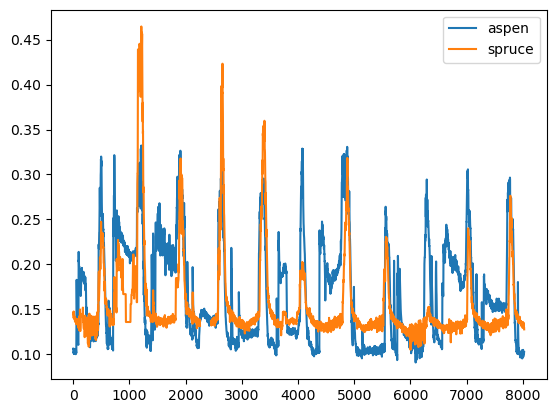

In [16]:
obs_soil.groupby('site')['vwc15'].plot(legend='True')

In [17]:
obs15Max = obs_soil.groupby([obs_soil.date.dt.year,obs_soil.site]).max().unstack().vwc15
obs15Max = obs_soil.groupby(obs_soil.site).max().unstack().vwc15
obs50Max = obs_soil.groupby(obs_soil.site).max().unstack().vwc50
obs15Max

site
aspen     0.332208
spruce    0.464542
dtype: object

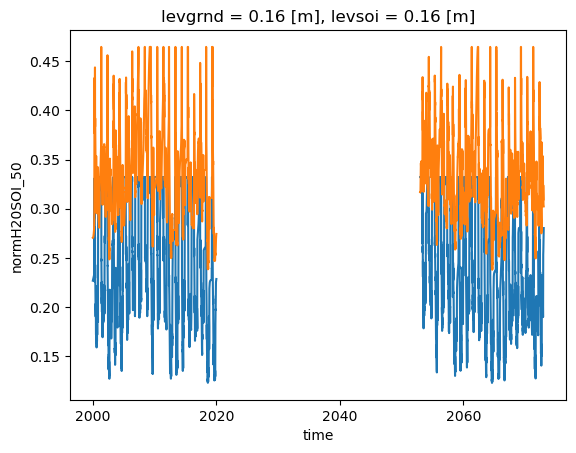

In [18]:
# Normalize soil moisure to soil level max
ds['normH2OSOI'] =  ds.H2OSOI / ds.H2OSOI.max('time')
ds_noLW['normH2OSOI'] =  ds_noLW.H2OSOI / ds_noLW.H2OSOI.max('time')
#ds.normH2OSOI.isel(lndgrid=0,levsoi=3).plot()
#ds_noLW.normH2OSOI.isel(lndgrid=0,levsoi=3).plot()

spd = 60 * 60 * 24
ds_asp = xr.Dataset()
ds_asp['TSOI_15'] = ds.TSOI.isel(lndgrid=0,levgrnd=3)
ds_asp['TSOI_50'] = ds.TSOI.isel(lndgrid=0,levgrnd=5)
ds_asp['normH20SOI_15'] = ds.normH2OSOI.isel(lndgrid=0,levsoi=3) * obs15Max[0]
ds_asp['normH20SOI_50'] = ds.normH2OSOI.isel(lndgrid=0,levsoi=5) * obs15Max[1]
ds_asp['RAIN'] = ds.RAIN.isel(lndgrid=0) * spd
ds_asp['SNOW'] = ds.SNOW.isel(lndgrid=0) * spd
ds_asp['normH20SOI_15'].plot()
ds_asp['normH20SOI_50'].plot() ;
fout = '/glade/derecho/scratch/wwieder/nldas/gothic/'+exp[0]+'daily.csv'
#ds_asp.to_dataframe().to_csv(fout)
#print(fout)

In [19]:
ds_hist = ds.isel(time=slice(0,(365*20)), lndgrid=0).groupby('time.dayofyear').mean()
ds_ssp = ds.isel(time=slice((-365*20),None), lndgrid=0).groupby('time.dayofyear').mean()

ds_hist2 = ds_noLW.isel(time=slice(0,(365*20)), lndgrid=0).groupby('time.dayofyear').mean()
ds_ssp2 = ds_noLW.isel(time=slice((-365*20),None), lndgrid=0).groupby('time.dayofyear').mean()

colors = ['tab:blue','tab:orange']
dsHist = xr.concat([ds_hist,ds_hist2],'sim').assign_coords({"sim": exp})
dsSSP = xr.concat([ds_ssp,ds_ssp2],'sim').assign_coords({"sim": exp})

### Plots for Hist vs. Obs

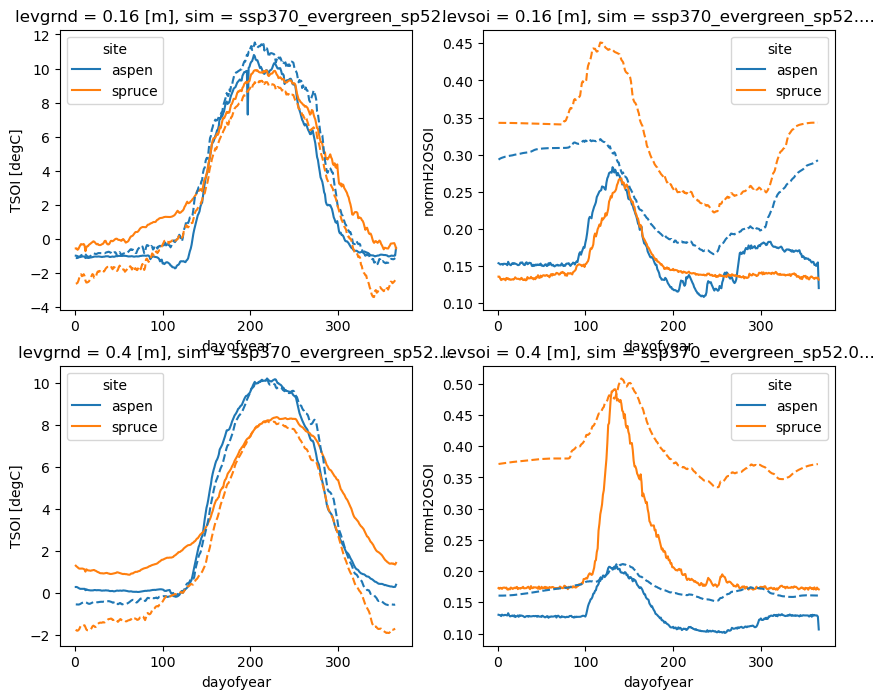

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))

obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().st15.plot(ax=axs[0,0]) ;
obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().st50.plot(ax=axs[1,0]) ;
obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().vwc15.plot(ax=axs[0,1]) ;
obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().vwc50.plot(ax=axs[1,1]) ;

for i in range(2):
    dsHist.TSOI.isel(levgrnd=3,sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[0,0])
    dsHist.TSOI.isel(levgrnd=5,sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[1,0])
    (dsHist.normH2OSOI.isel(levsoi=3,sim=i)*obs15Max[i]).plot(c=colors[i], linestyle='dashed', ax=axs[0,1])
    (dsHist.normH2OSOI.isel(levsoi=5,sim=i)*obs50Max[i]).plot(c=colors[i], linestyle='dashed', ax=axs[1,1])
    #dsHist.H2OSNO.isel(sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[1,1])


### Plots for Hist vs. SSP

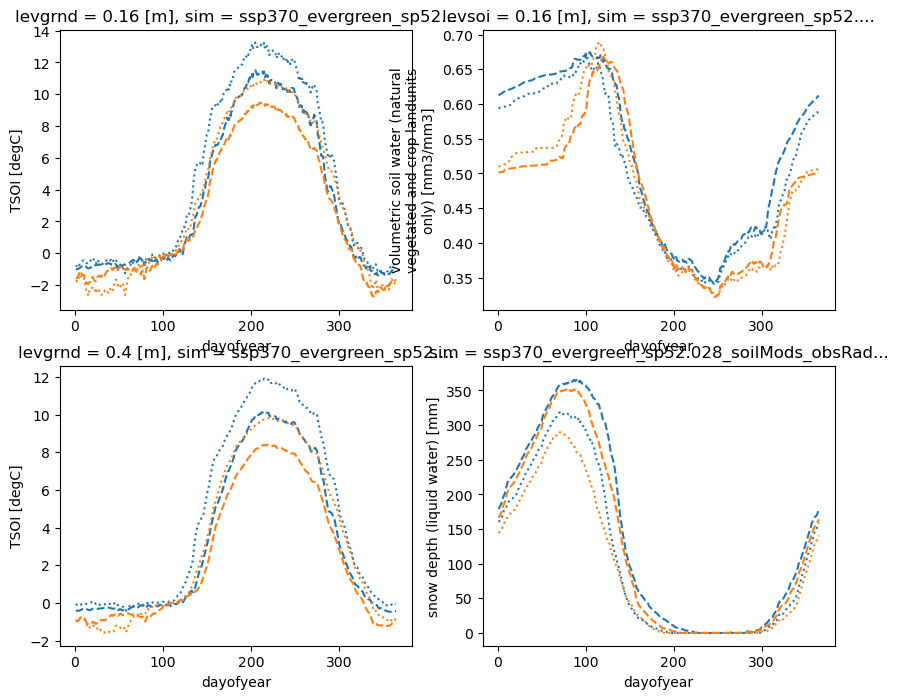

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
for i in range(2):
    dsHist.TSOI.isel(levgrnd=3,sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[0,0])
    dsSSP.TSOI.isel(levgrnd=3, sim=i).plot(c=colors[i], linestyle='dotted', ax=axs[0,0]) 

    dsHist.TSOI.isel(levgrnd=5,sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[1,0])
    dsSSP.TSOI.isel(levgrnd=5, sim=i).plot(c=colors[i], linestyle='dotted', ax=axs[1,0]) 

    dsHist.H2OSOI.isel(levsoi=3,sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[0,1])
    dsSSP.H2OSOI.isel(levsoi=3, sim=i).plot(c=colors[i], linestyle='dotted', ax=axs[0,1]) 

    dsHist.H2OSNO.isel(sim=i).plot(c=colors[i], linestyle='dashed', ax=axs[1,1])
    dsSSP.H2OSNO.isel(sim=i).plot(c=colors[i], linestyle='dotted', ax=axs[1,1]) ;

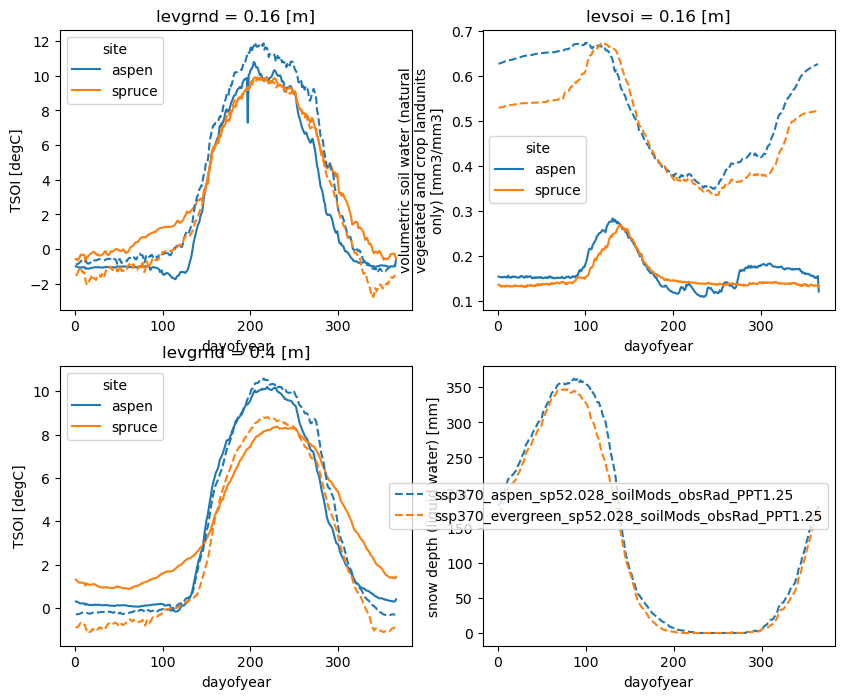

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().st15.plot(ax=axs[0,0]) ;
ds.TSOI.isel(levgrnd=3, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[0],ax=axs[0,0],color='tab:blue',linestyle="dashed") ;
ds_noLW.TSOI.isel(levgrnd=3, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[1],ax=axs[0,0],color='tab:orange',linestyle="dashed") ;

obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().st50.plot(ax=axs[1,0]) ;
ds.TSOI.isel(levgrnd=5, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[0],ax=axs[1,0],color='tab:blue',linestyle="dashed") ;
ds_noLW.TSOI.isel(levgrnd=5, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[1],ax=axs[1,0],color='tab:orange',linestyle="dashed") ;

obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().vwc15.plot(ax=axs[0,1]) ;
ds.H2OSOI.isel(levsoi=3, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[0],ax=axs[0,1],color='tab:blue',linestyle="dashed") ;
ds_noLW.H2OSOI.isel(levsoi=3, lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[1],ax=axs[0,1],color='tab:orange',linestyle="dashed") ;
#axs[0,1].legend()

ds.H2OSNO.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[0],ax=axs[1,1],color='tab:blue',linestyle="dashed") ;
ds_noLW.H2OSNO.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(
    label=exp[1],ax=axs[1,1],color='tab:orange',linestyle="dashed") ;
axs[1,1].legend() ;

In [29]:
ds

<xarray.Dataset>
Dimensions:     (time: 4746, lndgrid: 1, levgrnd: 25, levsoi: 20, levlak: 10,
                 levdcmp: 1)
Coordinates:
  * levgrnd     (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
  * levsoi      (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak      (levlak) float32 0.05 0.6 2.1 4.6 8.1 12.6 18.6 25.6 34.33 44.78
  * levdcmp     (levdcmp) float32 1.0
  * time        (time) object 2010-01-01 00:00:00 ... 2023-01-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/29)
    mcdate      (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mcsec       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mdcur       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mscur       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    nstep       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    lon         (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    ...          ...
    SNOW        (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    SNOW_DEPTH  (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    TBOT        (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    TSA         (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    TSOI        (time, levgrnd, lndgrid) float32 dask.array<chunksize=(3650, 25, 1), meta=np.ndarray>
    H2OSOI      (time, levsoi, lndgrid) float32 dask.array<chunksize=(3650, 20, 1), meta=np.ndarray>
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 10/01/24 14:30:43
    source:                               Community Terrestrial Systems Model
    hostname:                             derecho
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./ssp370_aspen_sp52.028_soilMods_ob...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

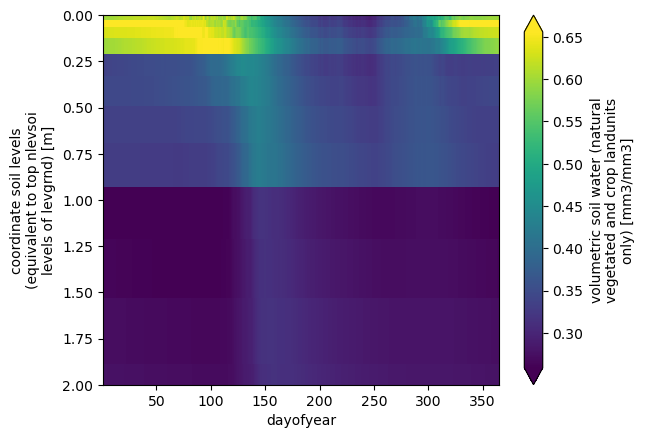

In [34]:
ds.H2OSOI.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(x='dayofyear',robust=True) ;
plt.ylim(0,2)
plt.gca().invert_yaxis()

''

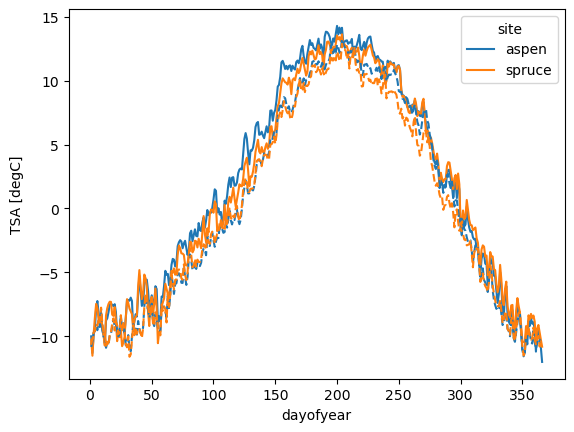

In [19]:
obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().airTC.plot() ;
ds.TSA.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(label=exp[0],color='tab:blue',linestyle="dashed") ;
ds_noLW.TSA.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(label=exp[1],color='tab:orange',linestyle="dashed") ;
#plt.legend() ;

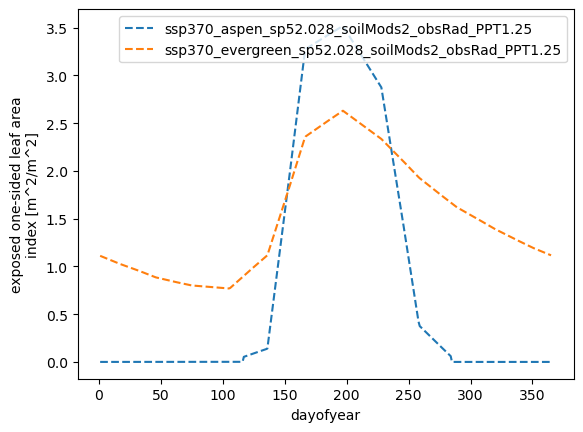

In [48]:
ds.ELAI.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(label=exp[0],color='tab:blue',linestyle="dashed") ;
ds_noLW.ELAI.isel(lndgrid=0).groupby('time.dayofyear').mean().plot(label=exp[1],color='tab:orange',linestyle="dashed") 
plt.legend() ;

In [41]:
  obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().airTC


site,aspen,spruce
date,,
1,-9.995386,-10.273064
2,-11.298034,-11.509682
3,-9.830375,-9.789186
4,-9.393614,-8.507754
5,-7.757451,-7.455625
...,...,...
362,-9.697413,-9.400254
363,-9.434705,-9.107875
364,-10.166117,-9.707614


-0.3844937191589215


-0.34322762261555956

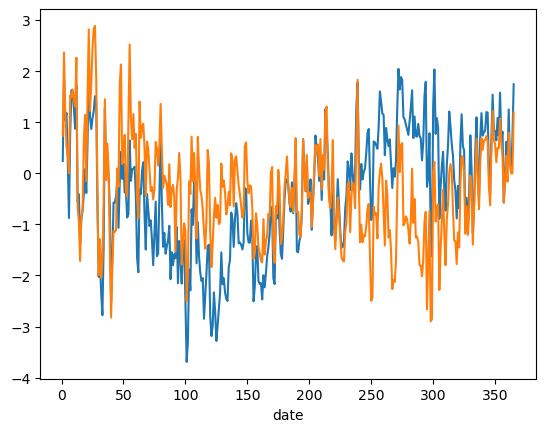

In [44]:
aspenBias = (ds.TSA.isel(lndgrid=0).groupby('time.dayofyear').mean().values - \
  obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().airTC['aspen'][0:-1])
aspenBias.plot()
print(aspenBias.mean())

spruceBias = (ds_noLW.TSA.isel(lndgrid=0).groupby('time.dayofyear').mean().values - \
  obs_soil.groupby([obs_soil.date.dt.dayofyear,obs_soil.site]).mean().unstack().airTC['spruce'][0:-1])
spruceBias.plot()
spruceBias.mean()

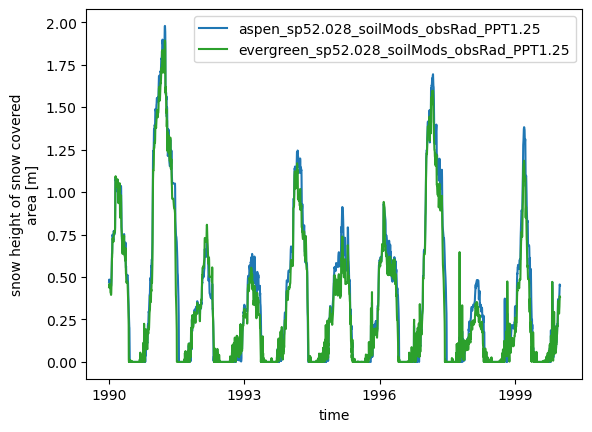

In [67]:
ds.SNOW_DEPTH.plot(label=exp[0])
ds_noLW.SNOW_DEPTH.plot(label=exp[1],color='tab:green') 
plt.legend();

Text(0, 0.5, 'Snow Depth (m)')

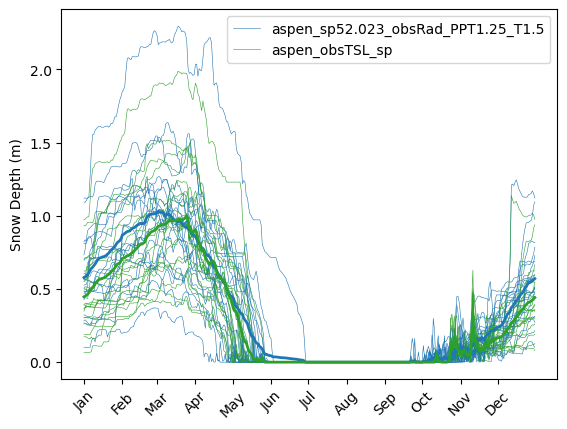

In [69]:
pltvar = 'SNOW_DEPTH'  #2008 & 2011 big snow years
for i in range(20):
    t0 = i*365
    t1 = (i+1)*365
    x = range(0,365)
    y = ds[pltvar].isel(time=slice(t0,t1)).isel(lndgrid=0)
    y2 = ds_noLW[pltvar].isel(time=slice(t0,t1)).isel(lndgrid=0)
    plt.plot(x,y,lw=0.4, color='tab:blue',label=exp[0])#'Aspen, Obs TLS (2000-2019)')
    plt.plot(x,y2,lw=0.4,color='tab:green', label=exp[1])#'Aspen, Obs SW no LW (2012-2022)')
    if i == 0: plt.legend() ;
Y = ds[pltvar].isel(lndgrid=0).groupby('time.dayofyear').mean()
Y2 = ds_noLW[pltvar].isel(lndgrid=0).groupby('time.dayofyear').mean()
plt.plot(x,Y,lw=2,color='tab:blue')
plt.plot(x,Y2,lw=2,color='tab:green')
plt.xticks(tick, month[0], rotation=45) 
plt.ylabel('Snow Depth (m)')

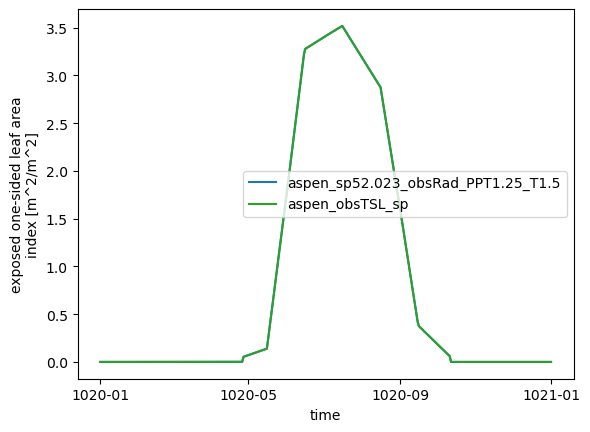

In [70]:
ds.ELAI.isel(time=slice(0,366)).plot(label=exp[0])
ds_noLW.isel(time=slice(0,366)).ELAI.plot(label=exp[1],color='tab:green')
plt.legend() ;

In [71]:
year = range(2000, 2020)
year_wy = range(2001, 2021)

# Subset observations to the same range
obs = obs_in[obs_in.year>=2000]
obs = obs[obs.year<=2020]
obs['mean_temp'] = (obs['maximum.temperature']+obs['minimum.temperature'])/2

### Make plots comparing model w/ observations

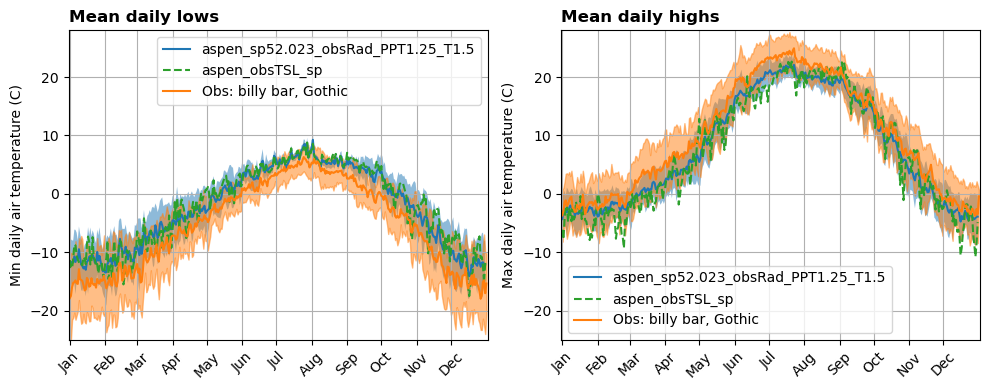

In [72]:
# Calculate climatology
Y1 = obs.groupby(obs.day_of_year).mean()
Y1b = obs.groupby(obs.day_of_year).std()
x1 = range(0,  366)

x2 = range(0,365)

# Plot min and max temperature
obs_var = ['minimum.temperature', 'maximum.temperature']
ylabel = ['Min daily air temperature (C)', 'Max daily air temperature (C)']
title = ['Mean daily lows', 'Mean daily highs']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    if i == 0: 
        Y2 = dsMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMin.groupby('time.dayofyear').std().isel(lndgrid=0)

        Z2 = ds_noLWMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        #Z2b = ds_noLWMin.groupby('time.dayofyear').std().isel(lndgrid=0)
    else:
        Y2 = dsMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMax.groupby('time.dayofyear').std().isel(lndgrid=0)
        Z2 = ds_noLWMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        #Z2b = ds_noLWMax.groupby('time.dayofyear').std().isel(lndgrid=0)

    axes[i].plot(x2, Y2, label = exp[0])
    axes[i].fill_between(x2, Y2-Y2b, Y2+Y2b, alpha=0.5)

    axes[i].plot(x2, Z2, label = exp[1], color='tab:green',linestyle="--")
    #axes[i].fill_between(x2, Z2-Z2b, Z2+Z2b, alpha=0.5)

    axes[i].set_xticks(tick, month[0], rotation=45)
    axes[i].set_xlim(-1, 366)
    axes[i].set_ylim(-25, 28)
    
    axes[i].plot(x1, Y1[obs_var[i]], label='Obs: billy bar, Gothic',color='tab:orange')
    axes[i].fill_between(x1, Y1[obs_var[i]] - Y1b[obs_var[i]], 
                         Y1[obs_var[i]] + Y1b[obs_var[i]], alpha=0.5,color='tab:orange')
    axes[i].set_ylabel(ylabel[i])
    axes[i].set_title(title[i],loc='left', fontsize='large', fontweight='bold')
    axes[i].legend()
    axes[i].grid() ;
    
fig.tight_layout()

In [73]:
(Y1[obs_var[i]][0:365]-Y2).mean()

1.8996743390597863

['minimum.temperature']
bb obs - NLDAS -2.784528102073928
NLDAS - Snody Climo -0.37332153
['maximum.temperature']
bb obs - NLDAS 1.8996743390597863
NLDAS - Snody Climo 0.41631398


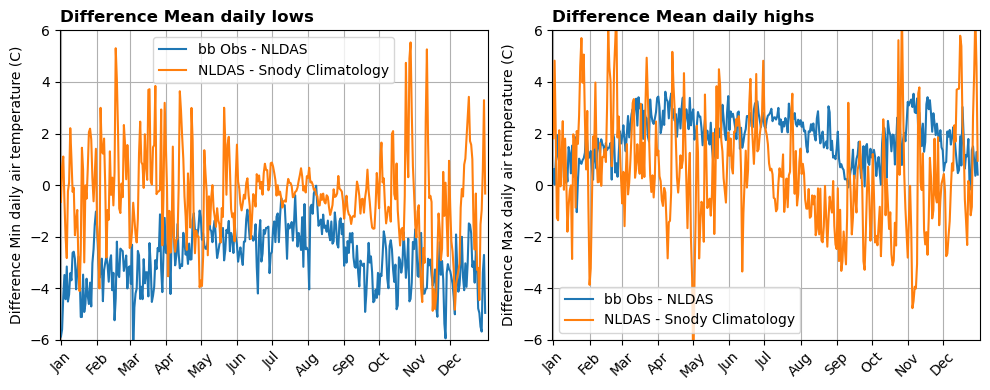

In [74]:
# Calculate climatology
Y1 = obs.groupby(obs.day_of_year).mean()
Y1b = obs.groupby(obs.day_of_year).std()
x1 = range(0,  366)

x2 = range(0,365)

# Plot min and max temperature
obs_var = ['minimum.temperature', 'maximum.temperature']
ylabel = ['Difference Min daily air temperature (C)', 'Difference Max daily air temperature (C)']
title = ['Difference Mean daily lows', 'Difference Mean daily highs']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    if i == 0: 
        Y2 = dsMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMin.groupby('time.dayofyear').std().isel(lndgrid=0)

        Z2 = ds_noLWMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        #Z2b = ds_noLWMin.groupby('time.dayofyear').std().isel(lndgrid=0)
    else:
        Y2 = dsMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMax.groupby('time.dayofyear').std().isel(lndgrid=0)
        Z2 = ds_noLWMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        #Z2b = ds_noLWMax.groupby('time.dayofyear').std().isel(lndgrid=0)

    axes[i].plot(x2, Y1[obs_var[i]][0:365]-Y2, label = 'bb Obs - NLDAS')
    axes[i].plot(x2, Y2-Z2, label = 'NLDAS - Snody Climatology')
    print([obs_var[i]])
    print("bb obs - NLDAS "+str((Y1[obs_var[i]][0:365]-Y2).mean()))
    print("NLDAS - Snody Climo "+str((Y2-Z2).mean().values))
    axes[i].set_xticks(tick, month[0], rotation=45)
    axes[i].set_xlim(-1, 366)
    axes[i].set_ylim(-6, 6)
    axes[i].set_ylabel(ylabel[i])
    axes[i].set_title(title[i],loc='left', fontsize='large', fontweight='bold')
    axes[i].legend()
    axes[i].grid() ;
    
fig.tight_layout()

Warmer nights and cooler days up @Snodgrass than down in Gothic

In [61]:
ds.TSA

<xarray.DataArray 'TSA' (time: 7300, lndgrid: 1)>
dask.array<transpose, shape=(7300, 1), dtype=float32, chunksize=(3650, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1020-01-01 00:00:00 ... 1039-12-31 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    units:    degC

**Should add TSA to output files, may be better than TBOT?**

#### NLDAS and Snodgrass met is providing: 
- warm nights (in the summer) and 
- cold days (all year), compared to billy's data

#### Look at water year precip and snow depth 

In [75]:
# cumulative precip from model
dsWY['cumSNOW'] = dsWY['SNOW'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY['cumRAIN'] = dsWY['RAIN'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY['cumPPT'] = dsWY['cumRAIN'] + dsWY['cumSNOW']

dsWY_noLW['cumSNOW'] = dsWY_noLW['SNOW'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY_noLW['cumRAIN'] = dsWY_noLW['RAIN'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY_noLW['cumPPT'] = dsWY_noLW['cumRAIN'] + dsWY_noLW['cumSNOW']

aspen_sp52.023_obsRad_PPT1.25_T1.5 cumPPT 86.88324
aspen_obsTSL_sp cumPPT 69.5066
aspen_sp52.023_obsRad_PPT1.25_T1.5 SNOW_DEPTH 1.0313929
aspen_obsTSL_sp SNOW_DEPTH 0.9871087


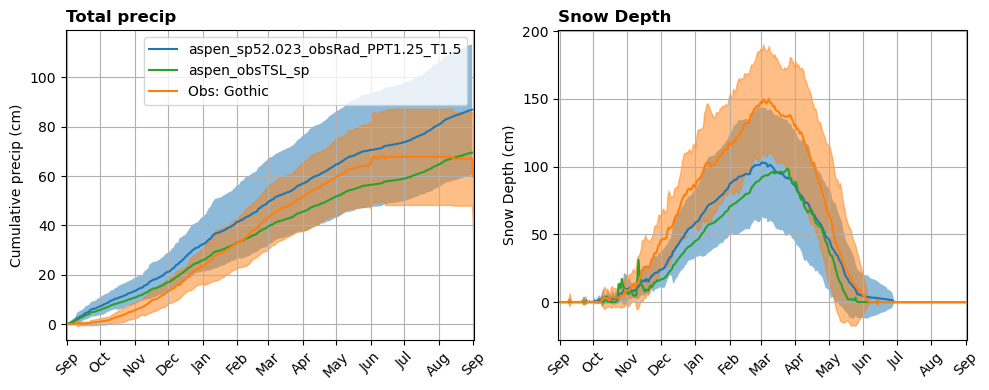

In [76]:
# calculate observed climatology by water year
Y1 = obs.groupby(obs.day_of_wateryear).mean()
Y1b = obs.groupby(obs.day_of_wateryear).std()

# can't compare obs and model snowfall, as the later is in mm of water
clm_var = ['cumPPT','SNOW_DEPTH','cumSNOW']
obs_var = ['sum.water.cm', 'snow.on.ground.cm','total.snow.cm']
ylabel = ['Cumulative precip (cm)', 'Snow Depth (cm)', 'Cumulative snow (cm)']
title = ['Total precip', 'Snow Depth', 'Total snow']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    Y2 = dsWY[clm_var[i]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    Y2b = dsWY[clm_var[i]].groupby('time.dayofyear').std().isel(lndgrid=0)
    print(exp[0]+' '+clm_var[i]+' '+str(Y2.max().values))
    Z2 = dsWY_noLW[clm_var[i]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    Z2b = dsWY_noLW[clm_var[i]].groupby('time.dayofyear').std().isel(lndgrid=0)
    print(exp[1]+' '+clm_var[i]+' '+str(Z2.max().values))
    if clm_var[i] == 'SNOW_DEPTH' :
        Y2 = Y2*100 # convert to cm
        Y2b = Y2b*100 # convert to cm
        Z2 = Z2*100 # convert to cm
        Z2b = Z2b*100 # convert to cm
        
    axes[i].plot(x2, Y2, label = exp[0])
    axes[i].fill_between(x2, Y2-Y2b, Y2+Y2b, alpha=0.5)
    axes[i].plot(x2,Z2,label=exp[1], color='tab:green',linestyle="-")
    #axes[i].fill_between(x2, Z2-Z2b, Z2+Z2b, alpha=0.5)
    axes[i].set_xticks(tick_wy, month_wy[0], rotation=45)
    axes[i].set_xlim(-1,366)
    
    axes[i].plot(x1,Y1[obs_var[i]],label='Obs: Gothic',color='tab:orange')
    axes[i].fill_between(x1, Y1[obs_var[i]] - Y1b[obs_var[i]],
                         Y1[obs_var[i]] + Y1b[obs_var[i]],
                         alpha=0.5,color='tab:orange')

    axes[i].set_ylabel(ylabel[i])
    axes[i].set_title(title[i], loc='left', fontsize='large', fontweight='bold')
    if i == 0: axes[i].legend()
    axes[i].grid() ;

fig.tight_layout()

#### Total precip OK? 
- Peak snow depth too low in CLM, maybe SWE OK?
- Snow persists too long in CLM?

---
#### Deeper look at model output

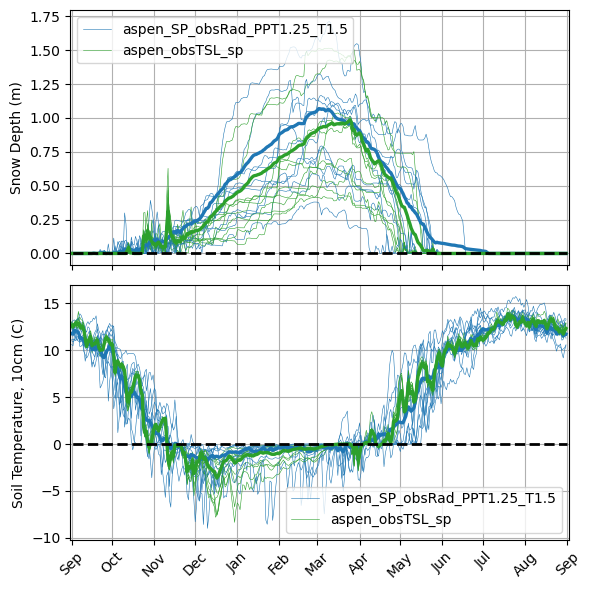

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
var = ['SNOW_DEPTH','TSOI']

yrange = range(9,19)
for v in range(0,2):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        y = dsWY[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        z = dsWY_noLW[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        if v == 1:
            y = y.isel(levgrnd=2) 
            z = z.isel(levgrnd=2) 
        x = range(0,365)
        axes[v].plot(x,y,lw=0.4,color='tab:blue')#label=str(year_wy[i]))
        axes[v].plot(x,z,lw=0.4,color='tab:green')#label=str(year_wy[i]))

    y = dsWY[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    y2 = dsWY[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    z = dsWY_noLW[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    z2 = dsWY_noLW[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    if v == 1:
        y = y.isel(levgrnd=2) 
        y2 = y2.isel(levgrnd=2) 
        z = z.isel(levgrnd=2) 
        z2 = z2.isel(levgrnd=2) 

    axes[v].plot(x,y,lw=2.4,color='tab:blue')
    #axes[v].fill_between(x, y-y2, y+y2, alpha=0.5,color='tab:blue')
    axes[v].plot(x,z,lw=2.4,color='tab:green')
    #axes[v].fill_between(x, z-z2, z+z2, alpha=0.5,color='tab:green' )
    axes[v].set_xticks(tick_wy, month_wy[0], rotation=45)
    if v == 0:
        axes[v].set_ylabel('Snow Depth (m)')
    else:
        axes[v].set_ylabel('Soil Temperature, 10cm (C)')
    axes[v].set_xlim(-1,366)
    axes[v].hlines(0,-10,365,color='k',lw=2,linestyles='dashed');
    axes[v].grid()
    axes[v].legend(exp)
fig.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=1) ;

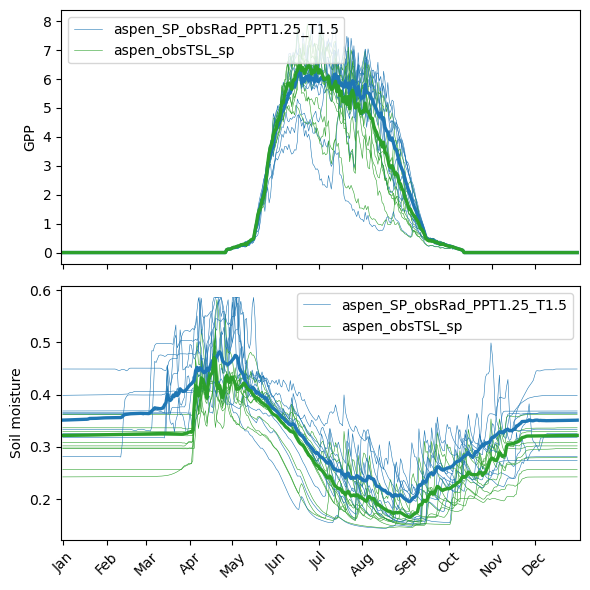

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
if SP == True:
    var = ['FPSN','H2OSOI']
else :
    var = ['GPP','H2OSOI']
    
#yrange = range(9,19)
for v in range(0,2):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        y = ds[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        z = ds_noLW[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        if v == 1:
            y = y.isel(levsoi=2) 
            z = z.isel(levsoi=2) 
        x = range(0,365)
        axes[v].plot(x,y,lw=0.4,color='tab:blue')#label=str(year_wy[i]))
        axes[v].plot(x,z,lw=0.4,color='tab:green')#label=str(year_wy[i]))

    y = ds[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    #y2 = ds[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    z = ds_noLW[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    #z2 = ds_noLW[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    if v == 1:
        y = y.isel(levsoi=2) 
        #y2 = y2.isel(levsoi=2) 
        z = z.isel(levsoi=2) 
        #z2 = z2.isel(levsoi=2) 

    axes[v].plot(x,y,lw=2.4,color='tab:blue')
    #axes[v].fill_between(x, y-y2, y+y2,color='tab:blue', alpha=0.5)
    axes[v].plot(x,z,lw=2.4,color='tab:green')
    #axes[v].fill_between(x, z-z2, z+z2,color='tab:green', alpha=0.5)
    axes[v].set_xticks(tick, month[0], rotation=45)
    if v == 0:
        axes[v].set_ylabel('GPP')
    else:
        axes[v].set_ylabel('Soil moisture')
    axes[v].set_xlim(-1,366)
    axes[v].legend(exp)

fig.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=1) ;

### How is interannual variability:
- Look at invidual years
- NOTE, this code is likely broken since we're reading now in H1 files in 1050 (from 1000 start)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


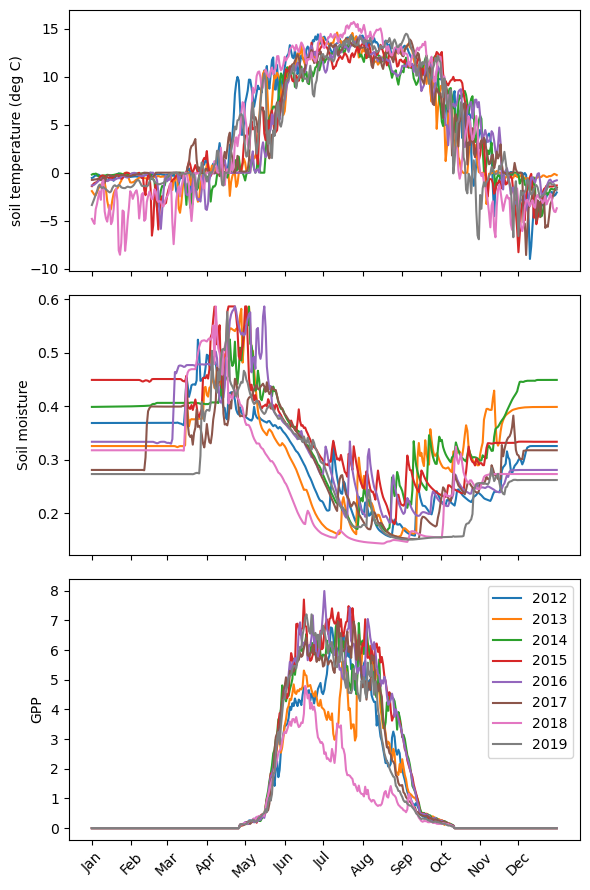

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(6,9), sharex=True)
    
yrange = range(12,20)
for v in range(3):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        if v == 0:
            y = ds.TSOI.isel(time=slice(t0,t1),levgrnd=2)
        if v == 1:
            y = ds.H2OSOI.isel(time=slice(t0,t1),levsoi=2)
        if v == 2:
            y = ds.FPSN.isel(time=slice(t0,t1))
            
        x = range(0,365)
        axes[v].plot(x,y,label=str(year[i]))
        axes[v].set_xticks(tick, month[0], rotation=45)
        
    axes[0].set_ylabel('soil temperature (deg C)')
    axes[1].set_ylabel('Soil moisture')
    axes[2].set_ylabel('GPP')
    plt.legend() ;

fig.tight_layout()


#### Driest years = 2012, 2013, 2018

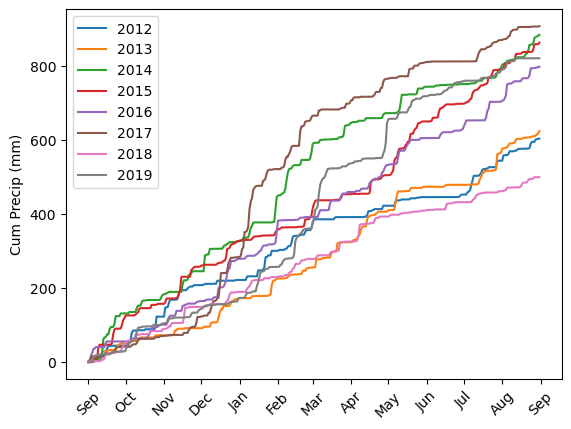

In [35]:
yrange = range(0,19)
spd = 3600*24
dsWY['PRECIP'] = (dsWY.SNOW + dsWY.RAIN)
WATERYEAR = np.empty(19)
RAIN = np.empty(19)
SNOW = np.empty(19)
for i in yrange:
    t0 = i*365
    t1 = (i+1)*365
    y = dsWY.PRECIP.isel(time=slice(t0,t1)).cumsum()*spd
    WATERYEAR[i] = int(year_wy[i])
    SNOW[i] = ((dsWY.SNOW.isel(time=slice(t0,t1)).cumsum()*spd).max().values)
    RAIN[i] = ((dsWY.RAIN.isel(time=slice(t0,t1)).cumsum()*spd).max().values)
    x = range(0,365)
    if i>10:
        plt.plot(x,y,label=str(year_wy[i]))
    
plt.xticks(tick_wy, month_wy[0], rotation=45)
plt.ylabel('Cum Precip (mm)')
plt.legend() ;

TOTAL = RAIN+SNOW

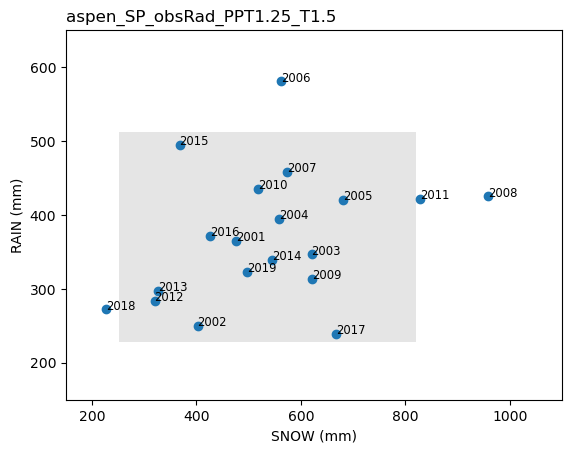

In [36]:
meanSNOW = SNOW.mean()
stdSNOW = SNOW.std()*1.644
meanRAIN = RAIN.mean()
stdRAIN = RAIN.std()*1.644

left, bottom, width, height = ((meanSNOW-stdSNOW), (meanRAIN-stdRAIN), 
                               (2*stdSNOW), (2*stdRAIN))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.1)

fig, ax = plt.subplots()
ax.add_patch(rect)
ax.scatter(SNOW,RAIN)

for i, txt in enumerate(WATERYEAR.astype(int)):
    ax.annotate(txt, (SNOW[i],RAIN[i]), fontsize='small')
plt.xlabel('SNOW (mm)')
plt.ylabel('RAIN (mm)')
plt.xlim(150,1100)
plt.ylim(150,650)
plt.title(exp[0], loc='left')
plt.show()

#### How does this compare with [Mariah's 2023 paper](https://iopscience.iop.org/article/10.1088/1748-9326/ad07b5/meta)?

----

#### Look a depth profiles of soil moisture
- likely need to adjust soil depth and properties for sites?

In [45]:
ds.isel(time=slice((18*365),(19*365))).time

<xarray.DataArray 'time' (time: 365)>
array([cftime.DatetimeNoLeap(1038, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1038, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1038, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1038, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1038, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1038, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1038-01-01 00:00:00 ... 1038-12-31 00:00:00

In [46]:
ds.time

<xarray.DataArray 'time' (time: 7300)>
array([cftime.DatetimeNoLeap(1020, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1020, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1020, 1, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1039, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1039, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1039, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1020-01-01 00:00:00 ... 1039-12-31 00:00:00

In [47]:
ds.levsoi.attrs = []
ds.H2OSOI.attrs['long_name'] = 'volumetric soil water'

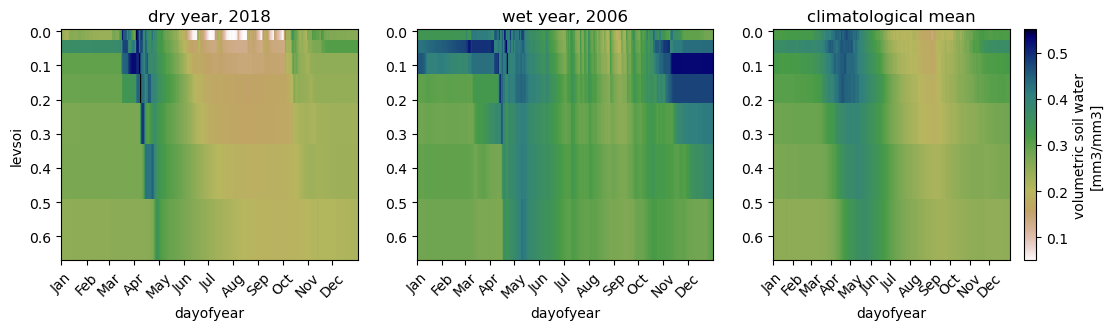

In [48]:
plt.figure(figsize=[13,3])
plt.subplot(1, 3, 1)
#ds.H2OSOI.groupby('time.dayofyear').min().isel(
ds.H2OSOI.isel(time=slice((18*365),(19*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,7)).plot(
    x='dayofyear',robust=True,vmin=0.05,vmax=0.55,cmap='gist_earth_r',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('dry year, 2018')

plt.subplot(1, 3, 2)
ds.H2OSOI.isel(time=slice((6*365),(7*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,7)).plot(
    x='dayofyear',robust=True,vmin=0.05,vmax=0.55,cmap='gist_earth_r',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('wet year, 2006')
plt.ylabel(None)

plt.subplot(1, 3, 3)
ds.H2OSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,7)).plot(
    x='dayofyear',vmin=0.05,vmax=0.55,cmap='gist_earth_r',add_colorbar=True)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('climatological mean')
plt.ylabel(None)

#ds.H2OSOI.groupby('time.dayofyear').max().isel(
#    lndgrid=0,levsoi=slice(0,9)).plot(
#    x='dayofyear',robust=True,vmin=0.0,vmax=0.6,cmap='gist_earth_r')
#plt.gca().invert_yaxis() ;
#plt.xticks(tick, month[0], rotation=45) ;
#plt.title('max')

fig.tight_layout()


In [49]:
ds.TSOI


<xarray.DataArray 'TSOI' (time: 7300, levgrnd: 25, lndgrid: 1)>
dask.array<transpose, shape=(7300, 25, 1), dtype=float32, chunksize=(3650, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * levgrnd  (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
  * time     (time) object 1020-01-01 00:00:00 ... 1039-12-31 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    units:    degC

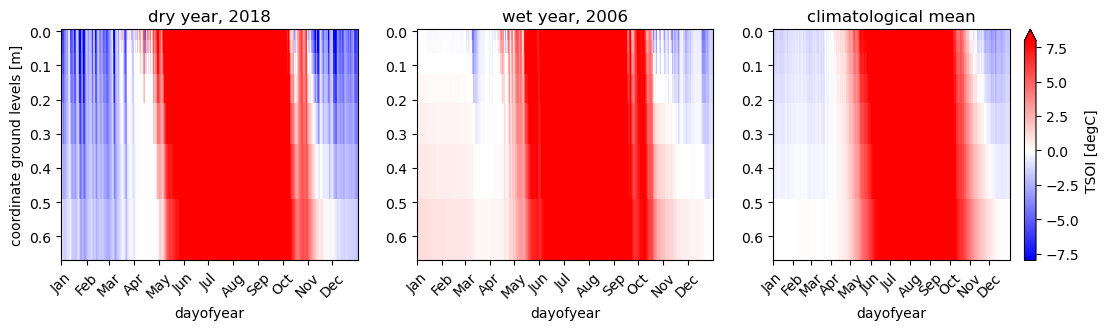

In [50]:
VMIN, VMAX = -8,8
plt.figure(figsize=[13,3])
plt.subplot(1, 3, 1)
#ds.H2OSOI.groupby('time.dayofyear').min().isel(
ds.TSOI.isel(time=slice((18*365),(19*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(0,7)).plot(
    x='dayofyear',vmin=VMIN,vmax=VMAX,cmap='bwr',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('dry year, 2018')

plt.subplot(1, 3, 2)
ds.TSOI.isel(time=slice((6*365),(7*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(0,7)).plot(
    x='dayofyear',vmin=VMIN,vmax=VMAX,cmap='bwr',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('wet year, 2006')
plt.ylabel(None)

plt.subplot(1, 3, 3)
ds.TSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(0,7)).plot(
    x='dayofyear',vmin=VMIN,vmax=VMAX,cmap='bwr',add_colorbar=True)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('climatological mean')
plt.ylabel(None)

fig.tight_layout()


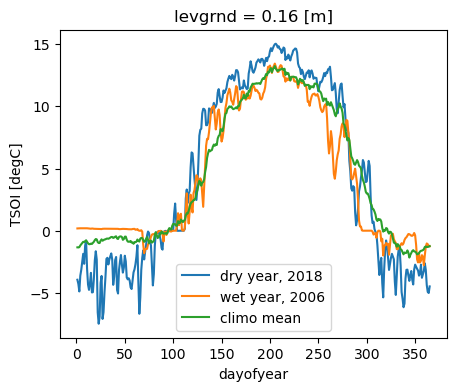

In [51]:
plt.figure(figsize=[5,4])
#ds.H2OSOI.groupby('time.dayofyear').min().isel(
ds.TSOI.isel(time=slice((18*365),(19*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(3,4)).plot(
    x='dayofyear', label='dry year, 2018')

ds.TSOI.isel(time=slice((6*365),(7*365))).groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(3,4)).plot(
    x='dayofyear', label='wet year, 2006')

ds.TSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levgrnd=slice(3,4)).plot(
    x='dayofyear',label='climo mean') 
plt.legend() ;

Text(0.5, 0, '')

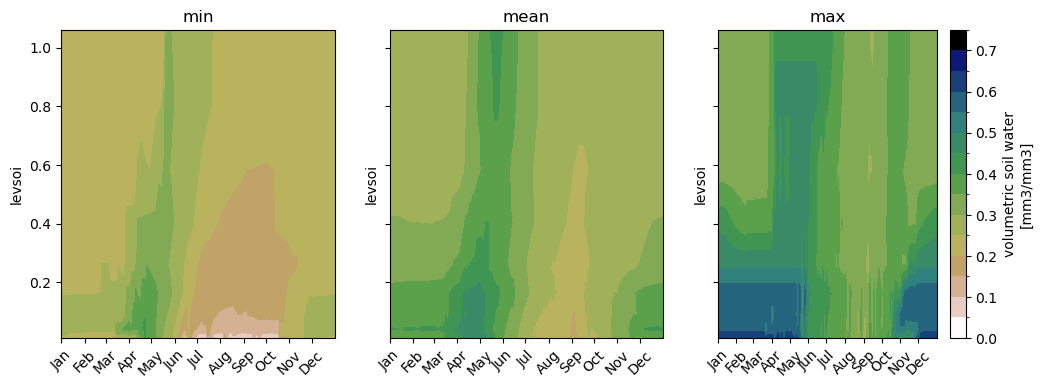

In [35]:
fig, axs = plt.subplots(ncols=3, nrows=1,
                        figsize=(12,4),
                        sharey=True)
[ax1, ax2, ax3] = axs

vmin=0.05
vmax=0.75
levels=[0,  0.05,0.1,0.15,0.2,0.25,0.3,0.35,
        0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]
cmap='gist_earth_r'

a = ds.H2OSOI.groupby('time.dayofyear').min().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax1,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax1.set_xticks(tick, month[0], rotation=45) ;
ax1.set_title('min')
ax1.set_xlabel(None)

a = ds.H2OSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax2,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax2.set_xticks(tick, month[0], rotation=45) ;
ax2.set_title('mean') ;
ax2.set_xlabel(None)

a = ds.H2OSOI.groupby('time.dayofyear').max().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax3,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = True)
ax3.set_xticks(tick, month[0], rotation=45) ;
ax3.set_title('max') ;
ax3.set_xlabel(None)

In [36]:
a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2012])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax4,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax4.set_title('2012, low snow + OK summer') ;

a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2013])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax5,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax5.set_title('2013, low snow, 2nd year drought') ;

a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2017])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax6,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax6.set_title('2017, high snow + dry summer') ;

plt.gca().invert_yaxis() ;
fig.subplots_adjust(right=.92) #also try using kwargs bottom, top, or hspace 
cbar_ax = fig.add_axes([0.95, 0.1, .02, .75]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax, orientation="vertical", 
             label=ds.H2OSOI.attrs['long_name']+" ("+ds.H2OSOI.attrs['units']+")") ;

NameError: name 'ax4' is not defined